Notebook purpose

- Determine appropriate model specifications

Background: 

- avg hh savings in uk: https://www.nimblefins.co.uk/savings-accounts/average-household-savings-uk#nogo

In [23]:
import contextlib
import os
import re
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.selectors as sl
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load raw data

In [2]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 2.03 seconds
Time for read_sample    : 4.62 minutes
(16,074,957, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1088993,2012-04-02,57,23.74,1982 01apr 12 the broadway fruiterer london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-23,True,NaN,NaN,NaN,NaN,NaN,u,201204,NaN,22542.600586,2.425209
1,1088994,2012-04-02,57,25.68,1982 01apr 12 waitrose 835 crouch end gb,waitrose,spend,household,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-08-15,True,NaN,waitrose,"food, groceries, household",NaN,supermarket,u,201204,NaN,22542.600586,2.425209


## Make analysis data

Make user-ym panel comprising dependent and independent variables

In [126]:
month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

column_makers = []


def column_adder(func):
    column_makers.append(func)
    return func


def trim_columns_upper(df, pct=0, ends="upper"):
    return df.apply(lambda x: hd.trim(x, pct=pct))


@column_adder
def obs_count(df):
    return df.groupby(idx_cols).id.count().rename("obs")


@column_adder
def account_balances(df):
    """Calculates average monthly balances for user's savings and current accounts."""
    return (
        df.loc[df.account_type.isin(["current", "savings"])]
        # daily account balances
        .groupby(
            ["user_id", "account_type", "account_id", "date"],
            observed=True,
        )
        .balance.first()
        # daily account type balances
        .groupby(["user_id", "account_type", "date"], observed=True)
        .sum()
        # monthly account type mean balance
        .reset_index()
        .set_index("date")
        .groupby(["user_id", "account_type"])
        .balance.resample("m")
        .mean()
        # reformat
        .unstack(level="account_type")
        .rename(columns={"current": "balance_ca", "savings": "balance_sa"})
    )


@column_adder
def savings_accounts_flows(df):
    """Calculates monthly inflows, outflows, and net-inflows into user's savings accounts.

    Also calculates scaled flows by dividing by users monthly income.
    """
    df = df.copy()
    df["debit"] = df.debit.replace({True: "sa_outflows", False: "sa_inflows"})
    is_not_interest_txn = ~df.tag_auto.str.contains("interest", na=False)
    is_savings_account = df.account_type.eq("savings")
    mask = is_not_interest_txn & is_savings_account
    group_cols = idx_cols + ["income", "debit"]

    return (
        df[mask]
        .groupby(group_cols)
        .amount.sum()
        .abs()
        .unstack()
        .fillna(0)
        .reset_index("income")
        .assign(
            sa_net_inflows=lambda df: df.sa_inflows - df.sa_outflows,
            sa_scaled_inflows=lambda df: df.sa_inflows / (df.income / 12),
            sa_scaled_outflows=lambda df: df.sa_outflows / (df.income / 12),
            sa_scaled_net_inflows=lambda df: df.sa_net_inflows / (df.income / 12),
        )
        .drop(columns="income")
    )


@column_adder
def total_monthly_spend(df):
    """Calculates total spend per user-month."""
    mask = df.tag_group.eq("spend")
    return df[mask].groupby(idx_cols).amount.sum().rename("total_monthly_spend")


@column_adder
def tag_monthly_spend(df):
    """Calculates spend per tag per user-month."""
    df = df.copy()
    df["tag"] = df.tag.cat.rename_categories(lambda x: "tag_spend_" + x)
    mask = df.tag_group.eq("spend")
    group_cols = idx_cols + ["tag"]
    df = df[mask].groupby(group_cols, observed=True).amount.sum().unstack().fillna(0)
    row_totals = df.sum(1)
    return df.div(row_totals, axis=0)
    return df


@column_adder
def constant_vars(df):
    """Add variables that are constant at the user-month level."""
    df["age"] = 2021 - df.user_yob
    cols = [
        "entropy_sptac",
        "income",
        "user_female",
        "age",
    ]
    return df.groupby(idx_cols)[cols].first()


def trim_columns(df, col_names, **kwargs):
    """Returns df with trimmed values for selected columns."""
    df = df.copy()
    df[col_names] = df[col_names].apply(hd.trim, **kwargs)
    return df


def main(df):
    data = pd.concat((func(df) for func in column_makers), axis=1)

    colnames_trim_upper = hd.colname_subset(data, "sa_(?:scaled_)?(?:inflows|outflows)")
    colnames_trim_both = hd.colname_subset(data, "balance|sa_scaled|entropy|spend")
    data = trim_columns(data, colnames_trim_upper, how="upper", pct=1)
    data = trim_columns(data, colnames_trim_both, how="both", pct=1)
    return data


filepath = "/Users/fgu/tmp/en/analysis_data_XX7.parquet"

# data = main(df)
# ha.write_parquet(data, filepath, index=True)

# data = ha.read_parquet(filepath)
# hd.inspect(data)

tag_monthly_spend(dfs)

tag                 tag_spend_finance  tag_spend_motor  tag_spend_household  \
user_id date                                                                  
7777    2012-11-30         110.115799           1.6475               1.6303   
        2012-12-31          10.515301           3.6109               2.0729   
        2013-01-31           7.584200           2.0807               2.8052   
        2013-02-28          10.588400           1.4931               1.6519   
        2013-03-31           6.831800           0.8693               2.4730   
...                               ...              ...                  ...   
582777  2018-08-31           0.000700           0.2000               2.7870   
        2018-09-30           0.004800           0.5005               3.8269   
        2018-10-31           0.000000           0.0000               2.8819   
        2018-11-30           0.000000           0.0000               2.8403   
        2018-12-31           0.457100           0.0000               2.9285   

tag                 tag_spend_retail  tag_spend_other_spend  \
user_id date                                                  
7777    2012-11-30            0.4810               4.840200   
        2012-12-31            1.0549              16.293001   
        2013-01-31            0.1798               1.546000   
        2013-02-28           -0.4151               3.503600   
        2013-03-31            0.8147               4.589500   
...                              ...                    ...   
582777  2018-08-31            1.5705               0.427500   
        2018-09-30            0.2471               0.700000   
        2018-10-31            0.9784               0.700000   
        2018-11-30            0.9293               0.100000   
        2018-12-31            1.0912               0.565000   

tag                 tag_spend_services  tag_spend_communication  \
user_id date                                                      
7777    2012-11-30              2.3084                   0.2297   
        2012-12-31              3.7507                   1.6829   
        2013-01-31              4.7498                   1.0306   
        2013-02-28              3.0405                   0.4470   
        2013-03-31              4.0294                   0.0999   
...                                ...                      ...   
582777  2018-08-31              2.6148                   8.9300   
        2018-09-30              2.5306                   0.2099   
        2018-10-31              5.6675                   0.2299   
        2018-11-30              4.3074                   0.2299   
        2018-12-31              3.0214                   0.2299   

tag                 tag_spend_travel  tag_spend_hobbies  
user_id date                                             
7777    2012-11-30            0.0000             0.0000  
        2012-12-31            0.0950             0.0000  
        2013-01-31            0.1105             0.0000  
        2013-02-28            0.0000             0.0000  
        2013-03-31            2.3180             0.0000  
...                              ...                ...  
582777  2018-08-31            0.0000             0.0000  
        2018-09-30            0.0000             0.0000  
        2018-10-31            0.0000             0.0000  
        2018-11-30            0.0000             0.0000  
        2018-12-31            0.1480             0.2699  

[1818 rows x 9 columns]

In [145]:
k = dfs.groupby(["user_id", "tag"]).amount.sum().unstack()
k.sum(1)
k.div(k.sum(1), axis=0)

tag,benefits,communication,earnings,finance,hobbies,household,motor,other_income,other_spend,other_transfers,pensions,retail,savings,services,travel
user_id,,,,,,,,,,,,,,,
7777,0.000000,0.088201,-3.498096,0.833304,0.003108,0.461099,0.219756,-0.002152,-0.321142,1.941864,0.000000,0.123365,0.000000,0.700174,0.450517
14777,0.068720,-0.223659,4.399871,-1.754747,-0.074111,-1.566252,-0.086881,-0.000000,-0.526293,2.353130,-0.000000,-0.280891,-0.000000,-0.502702,-0.806187
20777,-0.000000,-7.195300,104.046860,-5.028673,-0.090286,-43.444107,-2.335690,0.000013,-8.713835,-13.891941,-0.000000,-3.011448,-1.928771,-15.998777,-1.408054
26777,0.000000,0.024400,-3.132224,0.360695,0.126848,0.839137,0.061037,-0.001274,0.942846,0.482147,0.000000,0.109470,0.000000,1.047514,0.139404
58777,135.825562,-5.287066,-0.000000,-0.236855,-0.000000,-9.574983,-0.000000,-0.000000,-90.489899,-13.384102,-0.000000,-11.773932,-0.000000,-4.078721,-0.000000
64777,-0.090833,0.133923,-2.224176,0.448402,0.041848,0.847030,0.080850,-0.000634,0.322631,0.746873,0.000000,0.068708,0.077907,0.508170,0.039301
76777,-0.000000,-0.388503,16.095768,-1.393228,-0.015998,-7.841777,-1.235718,-0.000000,-0.793900,-1.080198,-0.000000,-0.011946,-0.000000,-2.008568,-0.325933
155777,-0.000000,-0.525748,6.426897,-0.348791,-0.211575,-1.072644,-0.124820,3.236333,-0.656587,-2.428827,-0.000000,-0.141949,-0.008165,-2.707220,-0.436905
179777,0.000000,0.020717,-0.273112,0.029422,0.002179,0.535106,0.060200,0.000000,0.339208,-0.024361,0.000000,0.106676,0.000000,0.160175,0.043792


### Validation

In [118]:
validator_funcs = []


def validator(func):
    """Adds func to validator functions."""
    validator_funcs.append(func)
    return func


@validator
def user_date_index(df):
    """Checks that index is user-date."""
    assert df.index.names == ["user_id", "date"]


def validate_data(df):
    for func in validator_funcs:
        func(df)


validate_data(data)

## Sumstats

In [10]:
def sumstats_table(df, cols):
    """Creats basic summary statistics table for colums."""
    order = ["count", "mean", "std", "min", "max", "25%", "50%", "75%"]
    return df[cols].describe().T[order]


def latex_sumstat_table(sumstats_table):
    return tabulate.tabulate(sumstats_table, headers="keys", tablefmt="latex_booktabs")


def write_table(table, path):
    """Writes printed table to path."""
    with open(path, "w+") as f:
        with contextlib.redirect_stdout(f):
            print(table)
    print(f"Table written to {path}.")


pattern = "\w"
cols = hd.colname_subset(data, pattern)
sumstats = sumstats_table(data, cols)
latex_sumstats = latex_sumstat_table(sumstats)
fp = os.path.join(config.TABDIR, "sumstats.tex")
write_table(latex_sumstats, fp)
sumstats

Table written to /Users/fgu/dev/projects/entropy/output/tables/sumstats.tex.


,count,mean,std,min,max,25%,50%,75%
obs,163915.0,98.068859,51.257414,11.000000,656.000000,63.000000,89.000000,123.000000
balance_ca,159116.0,1130.199463,4834.210938,-12257.117188,34628.589844,-884.007996,81.886841,1395.455078
balance_sa,64935.0,2625.156006,5496.725586,-1644.621460,42168.609375,2.210007,457.499939,2500.000000
sa_inflows,60583.0,780.843750,1507.547729,0.000000,13800.000000,60.000000,251.000000,790.385010
sa_outflows,60583.0,749.975220,1452.101318,0.000000,12075.480469,0.000000,200.000000,800.000000
sa_net_inflows,61195.0,75.746101,3330.151123,-69750.000000,120000.000000,-180.000000,17.700001,256.000000
sa_scaled_inflows,59977.0,0.335841,0.548266,0.000000,4.137818,0.031901,0.134704,0.383184
sa_scaled_outflows,59977.0,0.332819,0.576240,0.000000,4.039455,0.000000,0.105145,0.392159
sa_scaled_net_inflows,59971.0,0.007137,0.614697,-4.034811,4.184336,-0.084530,0.008627,0.133873
entropy_sptac,160635.0,2.569474,0.215097,1.902120,2.999520,2.432392,2.589158,2.727904


## Bivariate plots

In [11]:
data["entropy_pct"] = data.entropy_sptac.rank(pct=True)

In [159]:
def make_data(df, col_name, **trim_kws):
    return (
        df.set_index("entropy_pct", append=True)
        .loc[:, col_name]
        .rename("value")
        .reset_index("entropy_pct")
    )


def make_plot(df, axis):
    sns.regplot(
        data=df,
        y="value",
        x="entropy_pct",
        order=3,
        x_bins=20,
        x_ci=None,
        ci=95,
        ax=ax[axis],
    )

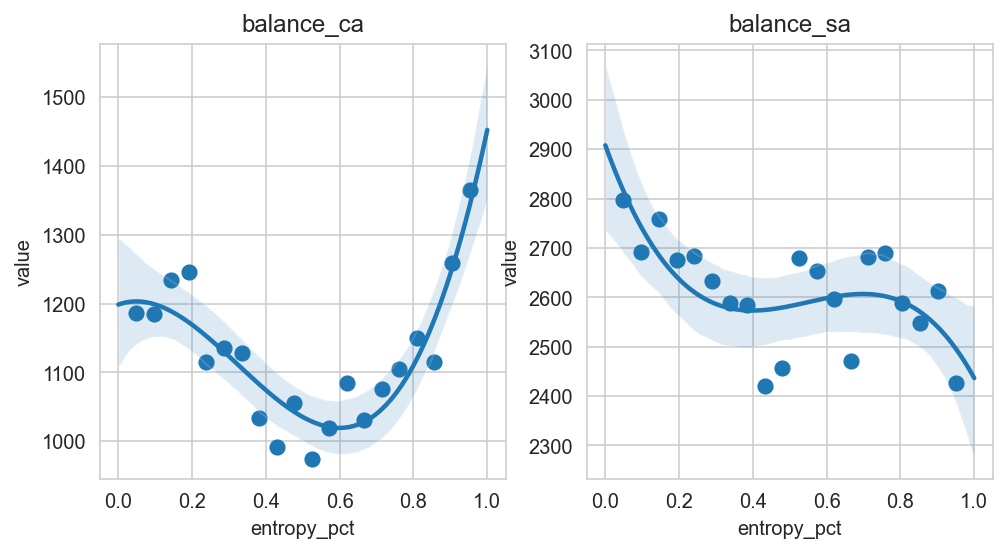

In [159]:
pattern = "balance_"
outcome_vars = colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

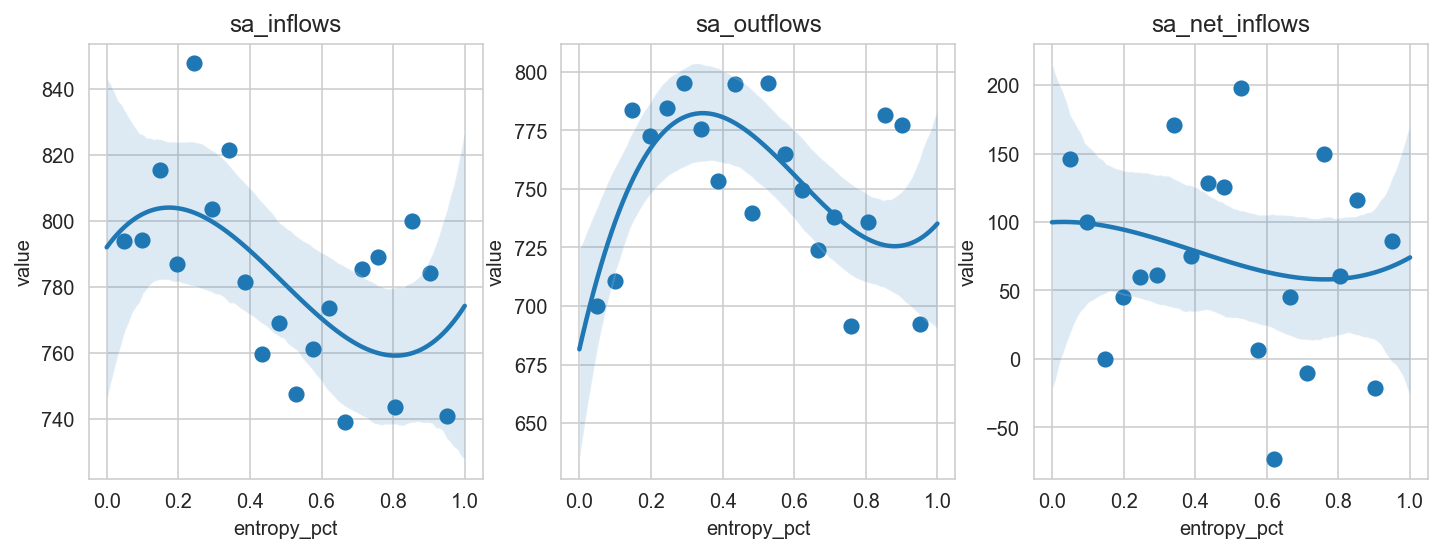

In [160]:
pattern = "sa_[oin]"
outcome_vars = colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

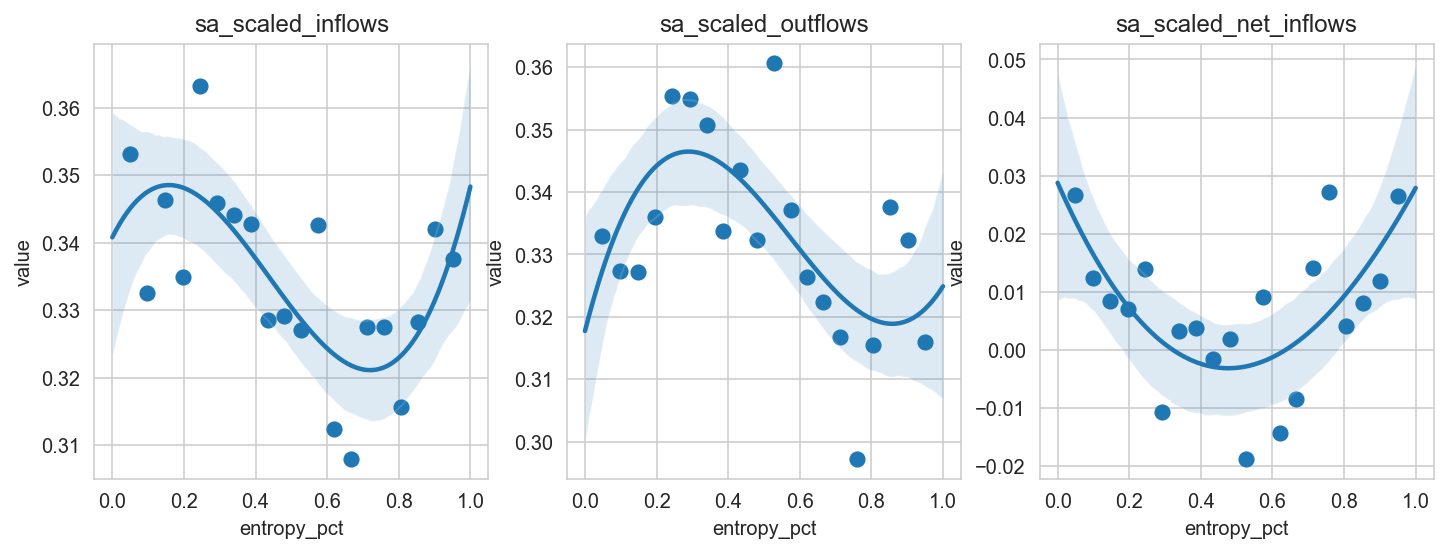

In [161]:
pattern = "sa_scaled"
outcome_vars = colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

## Main results

Full FE equation as baseline

todo:

- use prop of tag spends

- use PCA for training

- Understand effect of which tag spend dummy I drop



In [82]:
X_colnames = list(
    hd.colname_subset(data, "entropy_sptac|income|total_monthly_spend|tag_spend_")
)
X_colnames.remove("total_monthly_spend")
X = data[X_colnames]
y = data["sa_inflows"]

In [84]:
a = lm.PanelOLS(y, sm.add_constant(data["entropy_sptac"])).fit()
aa = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "income"]])).fit()
ab = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "income"]])).fit()
b = lm.PanelOLS(y, sm.add_constant(X)).fit()
c = lm.PanelOLS(y, X, entity_effects=True).fit()
d = lm.PanelOLS(y, X, entity_effects=True, time_effects=True).fit()
e = lm.PanelOLS(y, X, entity_effects=True, time_effects=True).fit(
    cov_type="clustered", cluster_entity=True
)

lm.panel.compare([a, aa, ab, b, c, d, e], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,59495,59495,59495,51773,51773,51773,51773
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered
R-squared,7.581e-05,0.0235,0.0235,0.0339,0.0042,0.0039,0.0039
R-Squared (Within),8.388e-05,0.0015,0.0015,0.0015,0.0042,0.0041,0.0041
R-Squared (Between),-0.0018,0.0501,0.0501,0.0742,0.2911,0.2876,0.2876
R-Squared (Overall),7.581e-05,0.0235,0.0235,0.0339,0.1547,0.1528,0.1528
F-statistic,4.5104,715.17,715.17,165.23,18.273,17.118,17.118
P-value (F-stat),0.0337,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
